# XAI Laboratory 01 - Tabular Methods

For this practice, you will need the following dataset:

- **fifa**: regression dataset containing FIFA players data:
    - short_name: name of the player
    - nationality
    - overall: overall score of the player (potential output)
    - potential: potential score of the player (potential output)
    - wage_eur: contract cancellation fine of the player (potential output)
    - value_eur: value in euros of the player (potential output)
    - age: age of the player in years
    - height_cm: height of the player in cm
    - weight_kg: weight of the player in kg
    - attacking_skills: several variables related to attacking
    - defending_skills: several variables related to defending
    - goalkeeping_skills: several variables related to goalkeeping

Use what you have learned from the `tabular_explanation.ipynb` notebook to complete the questions.

In [ ]:
!pip install numpy pandas scikit-learn shap xgboost matplotlib scipy lime
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# XAI
import shap
import lime
from alepython import ale_plot # You might need to install from source: pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(2025)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c3919dee0270fc60d3453032047d990d82dafe8023307482bf5540248e991d37
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-0dxrx_iy/alepython_302c1d6395ec4ce0881f200b8e1e5f1a
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-0dxrx_iy/alepython_302c1d6395ec4ce0881f200b8e1e5f1a
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.2 MB/s eta 0:00:00
  Created wheel for alepython: filename=alepython-0.

In [ ]:
### Load file --------------------------------------------
df = pd.read_csv('fifa.csv')
df.head()

,short_name,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,...,88,91,34,27,22,11,12,6,8,8


In [ ]:
X = df.drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)
y = df['value_eur']

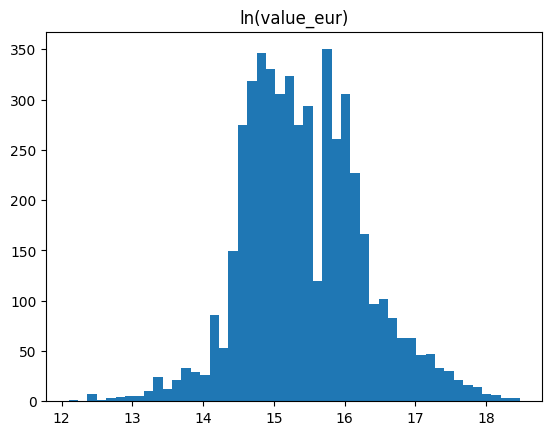

In [ ]:
# Change scale of output variable
ylog = np.log(y)

plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

In [ ]:
X_train, X_test, ylog_train, ylog_test, y_train, y_test = train_test_split(X, ylog, y, test_size=0.25, random_state=42)

In [ ]:
# Train XGBoost model, may take a few minutes
model = XGBRegressor()
model.fit(X_train, ylog_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
def predict_function(model, data):
    """Predict wrapper: original model was trained on log-output; return exp(pred) to recover original scale."""
    return np.exp(model.predict(data))

---
Ex 1. Ensure your model is not overfitted

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predictions
ylog_train_pred = model.predict(X_train)
ylog_test_pred = model.predict(X_test)

# checking if the model overfits or not
# If R^2 train and test are close, then the model generalizes well
r2_test = r2_score(ylog_test, ylog_test_pred)
r2_train = r2_score(ylog_train, ylog_train_pred)
rmse_train = np.sqrt(mean_squared_error(ylog_train, ylog_train_pred))
rmse_test = np.sqrt(mean_squared_error(ylog_test, ylog_test_pred))

print(f"Test R-squared: {r2_test:.4f}")
print(f"Train R-squared: {r2_train:.4f}")
print(f"Train RMSE:     {rmse_train:.4f}")
print(f"Test RMSE:      {rmse_test:.4f}")

# Since the values of R^2 on train and test are not very different,
# the model is not overfitted.


Test R-squared: 0.9163
Train R-squared: 0.9968
Train RMSE:     0.0480
Test RMSE:      0.2500


---
Ex 2. Obtain and plot variable importance measures using the following variable groups

In [ ]:
variable_groups = {
    'age': ['age'],
    'body': ['height_cm', 'weight_kg'],
    'attacking': ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys'],
    'skill': ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control'],
    'movement': ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance'],
    'power': ['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots'],
    'mentality': ['mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure'],
    'defending': ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle'],
    'goalkeeping' : ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
}

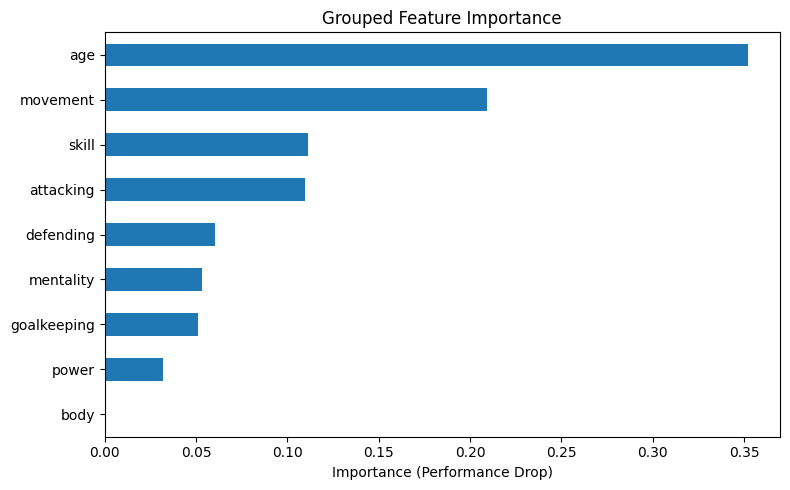

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

# Calculation of PFI
# we measure how much performance drops when we shuffle each feature
perm_imp = permutation_importance(
    model,
    X_test,
    ylog_test,
    n_repeats=5,
    random_state=42
)

# Creation of a series of importances
importances = pd.Series(perm_imp.importances_mean, index=X_test.columns)

# Calculation of the group importances using a loop
group_imp = {}
for group_name, features in variable_groups.items():
    group_imp[group_name] = importances[features].sum()

# Convertion to a Series, sort it,and plot it
pd.Series(group_imp).sort_values().plot(kind='barh', figsize=(8, 5))

# Adding labels and title to the graph
plt.xlabel("Importance (Performance Drop)")
plt.title("Grouped Feature Importance")
plt.tight_layout()
plt.show()

---
Ex 3. Obtain which is the variable with higher influence in Leo Messi's value. Justify which algorithm you choose

In [ ]:
import shap
import pandas as pd
import numpy as np

# Find Messi's data
try:
    messi_index = df[df['short_name'].str.contains('L. Messi')].index[0]

    if messi_index in X_train.index:
        messi_data = X_train.loc[[messi_index]]
        print("Found L. Messi in X_train.")
    elif messi_index in X_test.index:
        messi_data = X_test.loc[[messi_index]]
        print("Found L. Messi in X_test.")
    else:
        messi_data = X.loc[[messi_index]]
        print("Found L. Messi in the original X set.")

except (KeyError, IndexError):
    print("Error: Unable to find 'L. Messi' in the dataset.")
    messi_data = None

if messi_data is not None:
    # Initialize the SHAP Explainer

    X_train_summary = shap.kmeans(X_train, 100)

    def predict_fn_wrapper(X_numpy):
        X_df = pd.DataFrame(X_numpy, columns=X_train.columns)
        # prediction
        return model.predict(X_df)

    # Initialize the Kernel
    explainer = shap.KernelExplainer(predict_fn_wrapper, X_train_summary)

    # Calculate SHAP values of Messi , we also removed the loading bar for a
    # cleaner effect on the output
    shap_values = explainer.shap_values(messi_data, silent=True)

    # Find the feature with the highest contribution
    contributions = pd.Series(shap_values[0], index=X_train.columns)

    # Sort
    sorted_contributions = contributions.abs().sort_values(ascending=False)

    highest_influence_feature = sorted_contributions.index[0]
    highest_influence_value = contributions[highest_influence_feature]  # Value with sign

    print(f"\nFeature with the highest influence on Messi's predicted value: {highest_influence_feature}")
    print(f"SHAP value: {highest_influence_value:.4f}")

    # Print the top 5 contributions
    print("\n--- Top 5 Contributions ---")
    print(sorted_contributions.head(5))


Found L. Messi in X_train.

Feature with the highest influence on Messi's predicted value: movement_reactions
SHAP value: 1.3850

--- Top 5 Contributions ---
movement_reactions         1.384968
skill_ball_control         0.463003
attacking_finishing        0.288850
attacking_short_passing    0.250625
skill_dribbling            0.132837
dtype: float64


>>> Your justification here

> Algorithm used :SHAP TreeExplainer

We need to explain one single prediction (on Messi's value);this means we need a local explanation method.

The study guide notebook taught us that SHAP is the best tool for local explanations when we use a tree-based model.

So, we use shap and put in Messi's data.

---
Ex 4. Explain how perturbating the `height_cm` variable affect the value of Cristiano Ronaldo

Found Cristiano Ronaldo.


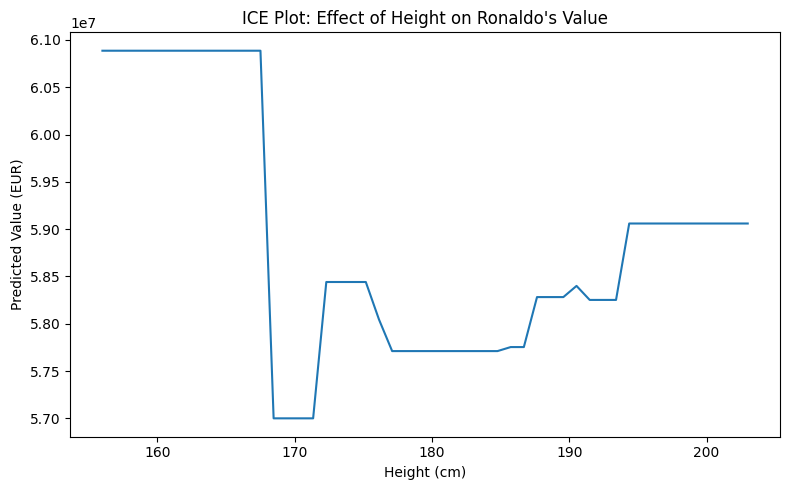

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Defining the prediction function
def predict_function(model, data):
    return np.exp(model.predict(data))

# Find Ronaldo's data
try:
    ronaldo_index = df[df['short_name'].str.contains('Cristiano Ronaldo')].index[0]
    ronaldo_data = X.loc[[ronaldo_index]]
    print(f"Found Cristiano Ronaldo.")
except (KeyError, IndexError):
    print("Error: Could not find 'Cristiano Ronaldo'.")
    ronaldo_data = None

if ronaldo_data is not None:

    # Create a grid of height values
    feature_name = 'height_cm'
    height_grid = np.linspace(X[feature_name].min(), X[feature_name].max(), 50)

    # Loop of heights and predictions
    all_predictions = []
    for height_value in height_grid:
        temp_data = ronaldo_data.copy()
        temp_data[feature_name] = height_value
        pred = predict_function(model, temp_data)
        all_predictions.append(pred[0])

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(height_grid, all_predictions)
    plt.xlabel("Height (cm)")
    plt.ylabel("Predicted Value (EUR)")
    plt.title("ICE Plot: Effect of Height on Ronaldo's Value")
    plt.tight_layout()
    plt.show()

 Your explanation here


We use an ICE plot to check how Ronaldo’s predicted value changes when we only adjust his height and keep all his other stats the same.

The very high values for short heights are just model errors — it doesn’t actually mean he’d be worth more if he were shorter. The model was trained on real players, so it probably never saw someone with Ronaldo’s skills but super short, so it gets confused.

That’s why we should only trust the part of the graph near his real height, around 187 cm.


---
Ex 5. Explain the average effect of the `age` variable on the model predictions. Does it differ greatly along the samples in the dataset? Which should be more affected by perturbating this variable, the goalkeepers or the strikers?

Generating PDP/ICE plots for 'age'...


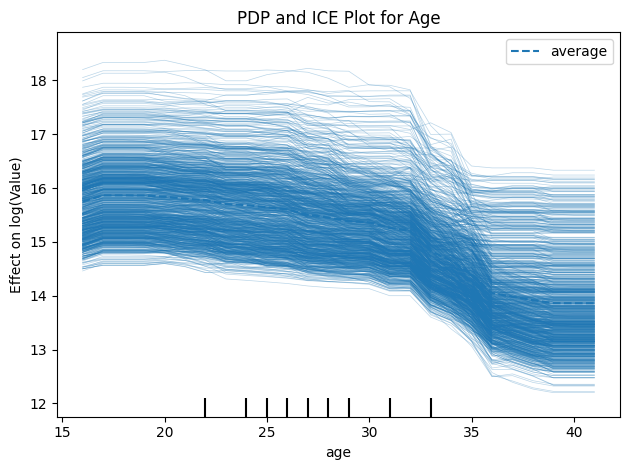

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

print(f"Generating PDP/ICE plots for 'age'...")

PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    ['age'],
    kind='both',
    grid_resolution=50
)

plt.title("PDP and ICE Plot for Age")
plt.ylabel("Effect on log(Value)")
plt.tight_layout()
plt.show()

>>> Your explanation here


The plot shows that the average value goes up until around 28–30 years old, then starts to drop.
Since the individual lines look almost the same, the effect of age is pretty consistent for all players; the model basically applies the same “age curve” to everyone.

---
Ex 6. Explain the prediction made for Hazard using a local surrogate model (Lime)

In [ ]:
import lime
import lime.lime_tabular


# Find Hazard's data
try:
    hazard_index = df[df['short_name'].str.contains('E. Hazard')].index[0]
    hazard_data = X.loc[[hazard_index]]
    print(f"Found E. Hazard.")
except (KeyError, IndexError):
    print("Error: Could not find 'E. Hazard'.")
    hazard_data = None

if hazard_data is not None:

    # Define LIME explainer
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,  # LIME needs numpy array for stats
        feature_names=X_train.columns.tolist(),
        mode='regression',
        random_state=42
    )

    # Define the prediction
    def lime_predict_fn(data_as_numpy):
        data_as_df = pd.DataFrame(data_as_numpy, columns=X_train.columns)
        log_preds = model.predict(data_as_df)
        return np.exp(log_preds).flatten()

    # Explain the instance
    exp = explainer.explain_instance(
        data_row=hazard_data.values[0],
        predict_fn=lime_predict_fn,
        num_features=10
    )

    # Show the explanation
    exp.show_in_notebook(show_table=True)

Found E. Hazard.
Calculating LIME explanation for E. Hazard...


Your explanation here

LIME explains Hazard’s prediction locally. It starts from a base value (415k) and shows which features make it go up or down to reach the final value (90M).
His top skills, like ball control and reactions, are the ones that boost his price the most. The plot is clear and really helpful to understand the result (even if the negative part is not well printed).